# GARCH Models Comparison

This notebook will implement GARCH(1,1) model for forecasting exchange rate volatility

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from scipy.stats import norm
import datetime as dt
import pandas_datareader.data as web
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox


Firstly, I read dataset using pandas datareader function, which receives KRW/USD dataset from FRED. The number of observation is 2824

In [2]:
start = dt.datetime(2010,1,2)
end = dt.datetime(2020,10,30)
currency_rate = web.DataReader('DEXKOUS', 'fred', start, end)
returns = 100 * currency_rate['DEXKOUS'].pct_change().dropna()
currency_rate['logprice'] = np.log(currency_rate.DEXKOUS)

logreturn = currency_rate['logprice'] - currency_rate['logprice'].shift(1)
logreturn = logreturn.dropna() * 100

data_df = pd.DataFrame(logreturn)
data_df.describe()

,logprice
count,2602.000000
mean,-0.006712
std,0.556675
min,-2.963028
25%,-0.311635
50%,-0.008352
75%,0.293213
max,3.147113


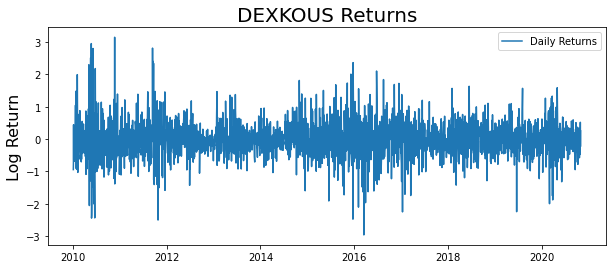

In [3]:
plt.figure(figsize=(10,4))
plt.plot(logreturn, label='Daily Returns')
plt.ylabel('Log Return', fontsize=16)
plt.title('DEXKOUS Returns', fontsize=20)
plt.legend(loc='upper right')
plt.show()

Can find the **clustering volatility** where the lower volatility is followed by other lower volatility and vice versa



Get partial autocorrelation coefficient where I can start with the time lag p and q for the models
The partial autocorrelation function indicates how much the current value is correlated with certain past values

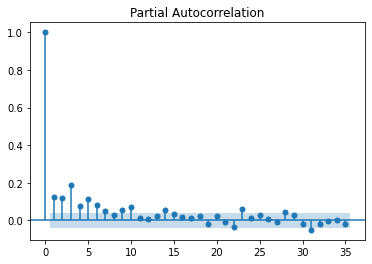

In [4]:
plot_pacf(logreturn**2)
plt.show()

According to partial autocorrelation graph, pacf of lag 3 has relatively high correlation in time series data

## Summaries of the Models

- **GARCH**
- **EGARCH**
- **GJR-GARCH**

In [5]:
gm = arch_model(logreturn, p=3, q=3, dist='t')

In [6]:
gm_res = gm.fit(disp='off')
gm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                     logprice   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                            GARCH   Log-Likelihood:               -1888.46
Distribution:      Standardized Student's t   AIC:                           3794.91
Method:                  Maximum Likelihood   BIC:                           3847.69
                                              No. Observations:                 2602
Date:                      Sun, Apr 18 2021   Df Residuals:                     2593
Time:                              14:20:08   Df Model:                            9
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0.0208  8.563e-03     -2.426  1.527e-02 [-3.755e-02,-3.989e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.5837e-03  5.000e-03      1.317      0.188 [-3.216e-03,1.638e-02]
alpha[1]       0.0591  2.232e-02      2.649  8.080e-03    [1.537e-02,  0.103]
alpha[2]       0.0391  6.983e-02      0.560      0.576   [-9.776e-02,  0.176]
alpha[3]       0.0445  2.813e-02      1.581      0.114 [-1.065e-02,9.961e-02]
beta[1]    6.0946e-16      1.080  5.644e-16      1.000      [ -2.116,  2.116]
beta[2]        0.2310      0.438      0.527      0.598      [ -0.628,  1.090]
beta[3]        0.6082      0.619      0.982      0.326      [ -0.605,  1.822]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.0977      0.678      8.990  2.464e-19 [  4.768,  7.427]
========================================================================

Covariance estimator: robust
"""

In [7]:
gm22 = arch_model(logreturn, p=2,q=2)
gm22.fit(disp='off').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               logprice   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1960.03
Distribution:                  Normal   AIC:                           3932.05
Method:            Maximum Likelihood   BIC:                           3967.23
                                        No. Observations:                 2602
Date:                Sun, Apr 18 2021   Df Residuals:                     2596
Time:                        14:20:09   Df Model:                            6
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0176  9.398e-03     -1.868  6.175e-02 [-3.598e-02,8.635e-04]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.6336e-03  1.854e-03      2.499  1.245e-02  [9.999e-04,8.267e-03]
alpha[1]       0.0729  2.159e-02      3.375  7.371e-04    [3.056e-02,  0.115]
alpha[2]   8.6202e-03  2.287e-02      0.377      0.706 [-3.621e-02,5.345e-02]
beta[1]        0.3752      0.160      2.339  1.936e-02    [6.073e-02,  0.690]
beta[2]        0.5290      0.151      3.512  4.442e-04      [  0.234,  0.824]
=============================================================================

Covariance estimator: robust
"""

In [8]:
gm_res.arch_lm_test()

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 299.2896
P-value: 0.0000
Distributed: chi2(28)
WaldTestStatistic, id: 0x7f5a94f81160

To see if there is ARCH effect, I used ARCH Lagrange Multiplier test.
According to the p-value of the result, it indicates that there is strong evidence of rejecting null hypothesis, which is residuals are homoskedastic.
Hence, the model has ARCH effect

EGARCH Model fit

In [9]:
egm = arch_model(logreturn, p=3, q=3, o=3, vol='egarch', dist='t')

In [10]:
egm_res = egm.fit(disp='off')
egm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - EGARCH Model Results                        
====================================================================================
Dep. Variable:                     logprice   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                           EGARCH   Log-Likelihood:               -1881.98
Distribution:      Standardized Student's t   AIC:                           3787.96
Method:                  Maximum Likelihood   BIC:                           3858.33
                                              No. Observations:                 2602
Date:                      Sun, Apr 18 2021   Df Residuals:                     2590
Time:                              14:20:12   Df Model:                           12
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0130  8.570e-03     -1.518      0.129 [-2.981e-02,3.784e-03]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega         -0.0281  1.362e-02     -2.066  3.885e-02 [-5.481e-02,-1.440e-03]
alpha[1]       0.0939  4.112e-02      2.283  2.241e-02     [1.330e-02,  0.174]
alpha[2]       0.0901  4.561e-02      1.976  4.821e-02     [7.099e-04,  0.179]
alpha[3]       0.0844  4.362e-02      1.936  5.290e-02    [-1.057e-03,  0.170]
gamma[1]       0.0815  2.812e-02      2.899  3.738e-03     [2.642e-02,  0.137]
gamma[2]       0.0420  4.243e-02      0.991      0.322    [-4.111e-02,  0.125]
gamma[3]       0.0146  4.122e-02      0.355      0.723  [-6.617e-02,9.541e-02]
beta[1]    9.5370e-14      0.283  3.375e-13      1.000       [ -0.554,  0.554]
beta[2]        0.3074      0.207      1.485      0.137    [-9.821e-02,  0.713]
beta[3]        0.6644      0.194      3.433  5.973e-04       [  0.285,  1.044]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.1555      0.692      8.899  5.648e-19 [  4.800,  7.511]
========================================================================

Covariance estimator: robust
"""

In [11]:
egm_res.arch_lm_test()

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 299.0961
P-value: 0.0000
Distributed: chi2(28)
WaldTestStatistic, id: 0x7f5a94eda1f0

The EGARCH model also shows the powerful p-value.
Again, I confirmed that the ARCH effect exists

GJR-GARCH fit

In [12]:
gjr = arch_model(logreturn, p=3, q=3, o=3,vol = 'garch', dist='t')
gjr_res = gjr.fit(disp='off')
gjr_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                     logprice   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1880.63
Distribution:      Standardized Student's t   AIC:                           3785.27
Method:                  Maximum Likelihood   BIC:                           3855.63
                                              No. Observations:                 2602
Date:                      Sun, Apr 18 2021   Df Residuals:                     2590
Time:                              14:20:21   Df Model:                           12
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0153  8.644e-03     -1.772  7.647e-02 [-3.225e-02,1.628e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      5.0912e-03  2.261e-03      2.252  2.434e-02  [6.597e-04,9.523e-03]
alpha[1]       0.0937  3.165e-02      2.961  3.064e-03    [3.169e-02,  0.156]
alpha[2]       0.0468  2.940e-02      1.593      0.111   [-1.080e-02,  0.104]
alpha[3]       0.0415  4.136e-02      1.003      0.316   [-3.960e-02,  0.123]
gamma[1]      -0.0762  3.335e-02     -2.284  2.237e-02   [ -0.142,-1.081e-02]
gamma[2]      -0.0309  3.165e-02     -0.975      0.330 [-9.289e-02,3.118e-02]
gamma[3]      -0.0326  4.517e-02     -0.723      0.470    [ -0.121,5.589e-02]
beta[1]    1.0383e-10      0.172  6.043e-10      1.000      [ -0.337,  0.337]
beta[2]        0.2480      0.152      1.627      0.104   [-5.069e-02,  0.547]
beta[3]        0.6222      0.150      4.141  3.462e-05      [  0.328,  0.917]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.2471      0.711      8.785  1.561e-18 [  4.853,  7.641]
========================================================================

Covariance estimator: robust
"""

In [13]:
gjr_res.arch_lm_test()

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 299.1645
P-value: 0.0000
Distributed: chi2(28)
WaldTestStatistic, id: 0x7f5a94e61a30

Same as GJR-GARCH model

To summarise so far, I testified two preconditions for modeling GARCH models. The preconditions are the presence of clustering volatility and ARCH effect.


Plot all of the models to compare with the actual returns

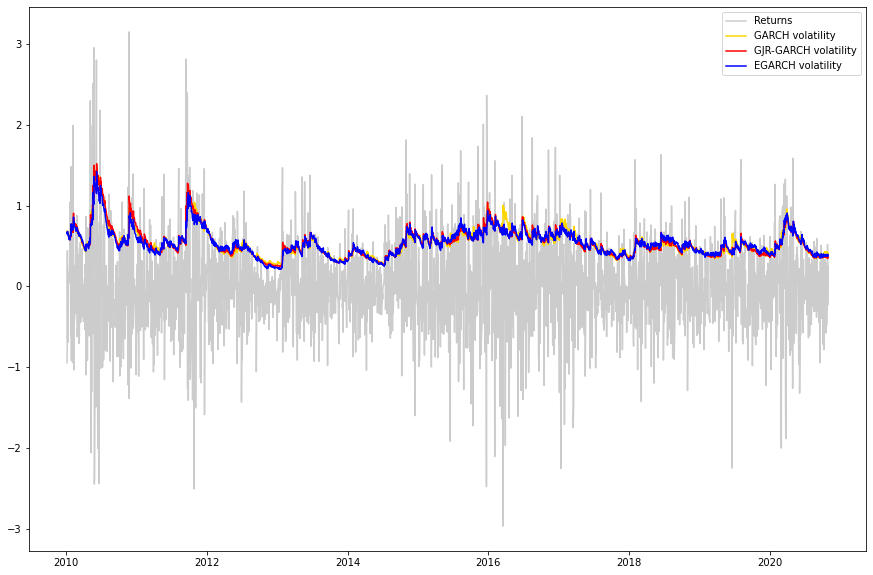

In [14]:
plt.figure(figsize=(15,10))
plt.plot(logreturn, color='grey', alpha=0.4, label = 'Returns')
plt.plot(gm_res.conditional_volatility, color = 'gold', label = 'GARCH volatility')
plt.plot(gjr_res.conditional_volatility, color='red', label = 'GJR-GARCH volatility')
plt.plot(egm_res.conditional_volatility, color='blue', label = 'EGARCH volatility')

plt.legend(loc = 'upper right')
plt.show()

In [72]:
print('GARCH(3,3) log-likelihood: ', gm_res.loglikelihood)
print('EGARCH(3,3) log-likelihood: ', egm_res.loglikelihood)
print('GJR-GARCH(3,3) log-likelihood: ', gjr_res.loglikelihood)
print('\n')

print('GARCH(3,3) AIC: ', gm_res.aic)
print('EGARCH(3,3) AIC: ', egm_res.aic)
print('GJR-GARCH(3,3) AIC: ', gjr_res.aic)
print('\n')

print('GARCH(3,3) BIC: ', gm_res.bic)
print('EGARCH(3,3) BIC: ', egm_res.bic)
print('GJR-GARCH(3,3) BIC: ', gjr_res.bic)

GARCH(3,3) log-likelihood:  -1888.4550640266955
EGARCH(3,3) log-likelihood:  -1881.9811813796264
GJR-GARCH(3,3) log-likelihood:  -1880.6325283459678


GARCH(3,3) AIC:  3794.910128053391
EGARCH(3,3) AIC:  3787.9623627592528
GJR-GARCH(3,3) AIC:  3785.2650566919356


GARCH(3,3) BIC:  3847.686448985043
EGARCH(3,3) BIC:  3858.330790668122
GJR-GARCH(3,3) BIC:  3855.633484600805


## Forecasting with the models

Forecast the volatility of DEXKOUS with them using Recursive forecast generation method. 
To evaluate, I used Mean Squared Error(MSE) and Mean Absolute Error (MAE)

First one is GARCH(3,3) model 

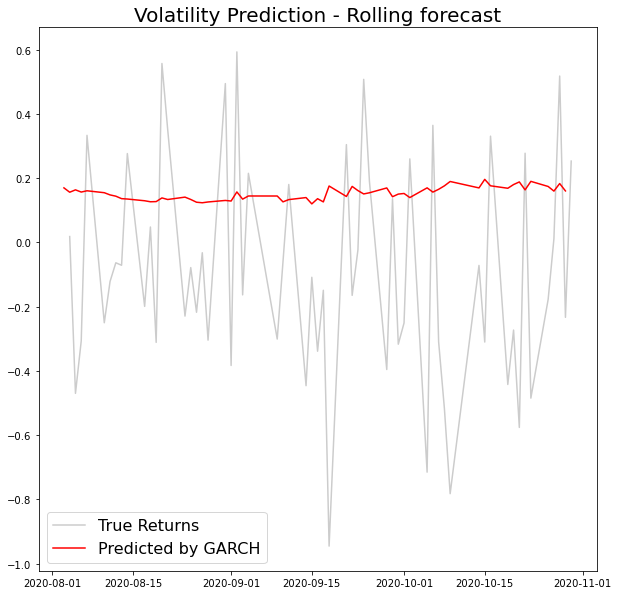

Mean squared error: 0.176
Mean absolute error: 0.356


In [88]:
rolling_predictions = {}
test_size = 60
end_loc = len(logreturn)-test_size
train = 0
for i in range(test_size):
    train = logreturn[:-(test_size-i)]
    gm = arch_model(train, p=3, q=3)
    model_fit = gm.fit(first_obs=i, last_obs=i+end_loc,disp='off')
    pred = model_fit.forecast(horizon=1).variance
    fcast = pred.iloc[i+end_loc - 1]
    rolling_predictions[fcast.name] = fcast

rolling_predictions = pd.DataFrame(rolling_predictions).T

plt.figure(figsize=(10,10))
plt.plot(logreturn[-test_size:], alpha=0.4,color= 'grey')
plt.plot(rolling_predictions, color='red')
plt.title('Volatility Prediction - Rolling forecast', fontsize = 20)
plt.legend(['True Returns', 'Predicted by GARCH'], fontsize=16)
plt.show()

mse_gm = mean_squared_error(logreturn[-test_size:], rolling_predictions)
print("Mean squared error: {:.3g}".format(mse_gm))

mae_gm = mean_absolute_error(logreturn[-test_size:], rolling_predictions)
print("Mean absolute error: {:.3g}".format(mae_gm))


The following model is EGARCH(3,3) model

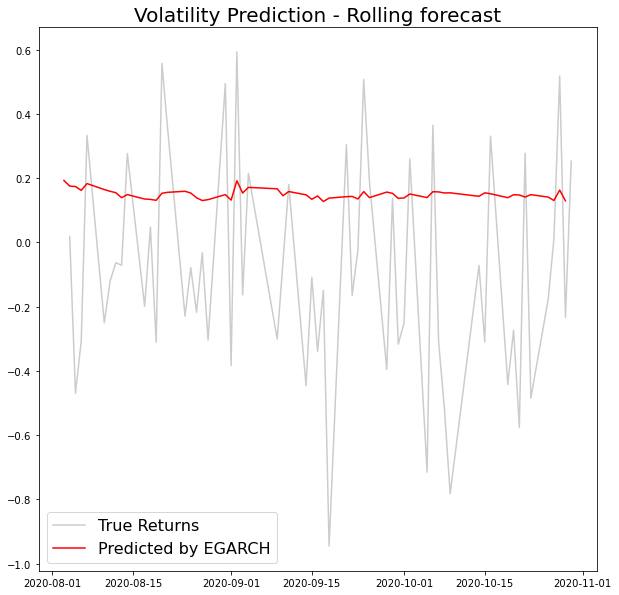

Mean squared error: 0.177
Mean absolute error: 0.359


In [89]:
rolling_predictions = {}

for i in range(test_size):
    train = logreturn[:-(test_size-i)]
    gm = arch_model(train, p=3, q=3,o=3, vol='egarch')
    model_fit = gm.fit(first_obs=i, last_obs=i+end_loc,disp='off')
    pred = model_fit.forecast(horizon=1).variance
    fcast = pred.iloc[i+end_loc - 1]
    rolling_predictions[fcast.name] = fcast

rolling_predictions = pd.DataFrame(rolling_predictions).T

plt.figure(figsize=(10,10))
plt.plot(logreturn[-test_size:], alpha=0.4,color= 'grey')
plt.plot(rolling_predictions, color='red')
plt.title('Volatility Prediction - Rolling forecast', fontsize = 20)
plt.legend(['True Returns', 'Predicted by EGARCH'], fontsize=16)
plt.show()

mse_egm = mean_squared_error(logreturn[-test_size:], rolling_predictions)
print("Mean squared error: {:.3g}".format(mse_egm))

mae_egm = mean_absolute_error(logreturn[-test_size:], rolling_predictions)
print("Mean absolute error: {:.3g}".format(mae_egm))


The last one is GJR-GARCH(1,1) model

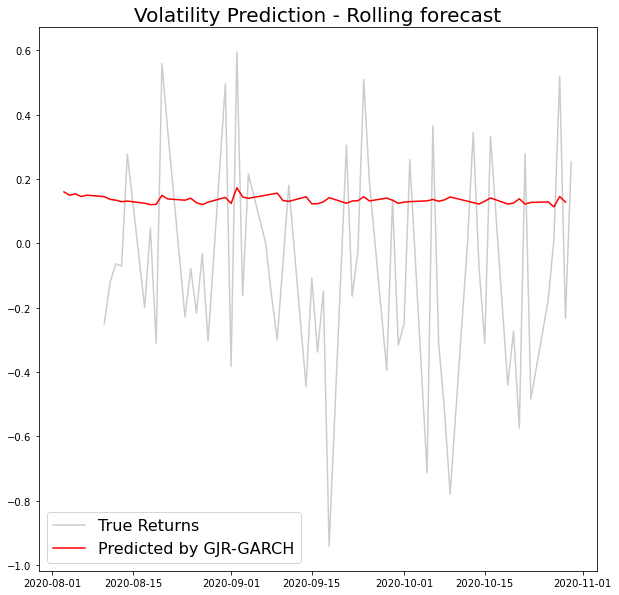

Mean squared error: 0.168
Mean absolute error: 0.349


In [87]:
rolling_predictions = {}

for i in range(test_size):
    train = logreturn[:-(test_size-i)]
    gm = arch_model(train, p=3, q=3,o=3)
    model_fit = gm.fit(first_obs=i, last_obs=i+end_loc,disp='off')
    pred = model_fit.forecast(horizon=1).variance
    fcast = pred.iloc[i+end_loc - 1]
    rolling_predictions[fcast.name] = fcast

rolling_predictions = pd.DataFrame(rolling_predictions).T
plt.figure(figsize=(10,10))
plt.plot(returns[-test_size:], alpha=0.4,color= 'grey')
plt.plot(rolling_predictions, color='red')
plt.title('Volatility Prediction - Rolling forecast', fontsize = 20)
plt.legend(['True Returns', 'Predicted by GJR-GARCH'], fontsize=16)
plt.show()

mse_gjr = mean_squared_error(logreturn[-test_size:], rolling_predictions)
print("Mean squared error: {:.3g}".format(mse_gjr))

mae_gjr = mean_absolute_error(logreturn[-test_size:], rolling_predictions)
print("Mean absolute error: {:.3g}".format(mae_gjr))


In [91]:
print('Mean squared error\n')
print('GARCH: {:.3g}', mse_gm)
print('EGARCH: {:.3g}', mse_egm)
print('GJR-GARCH: {:.3g}', mse_gjr)
print('\n')
print('Mean absolute error\n')
print('GARCH: {:.3g}', mae_gm)
print('EGARCH: {:.3g}', mae_egm)
print('GJR-GARCH: {:.3g}', mae_gjr)

Mean squared error

GARCH: {:.3g} 0.17630472276454953
EGARCH: {:.3g} 0.17724515195486043
GJR-GARCH: {:.3g} 0.16809240134975365


Mean absolute error

GARCH: {:.3g} 0.3557765967773912
EGARCH: {:.3g} 0.35907935096963955
GJR-GARCH: {:.3g} 0.34912163300061266
